In [9]:
import cv2
import numpy as np
import os
import radialProfile
import glob
from matplotlib import pyplot as plt
import pickle
from scipy.interpolate import griddata

data= {} # 用于存储最终的特征数据和标签
epsilon = 1e-8 # epsilon是一个很小的常数，用于数值稳定性。
N = 300 # N定义了功率谱密度(PSD)的采样点数。
y = []
error = [] # y和error是空列表，用于存储计算出的PSD均值和标准差

number_iter = 1600 # number_iter定义了迭代次数，即处理的图像数量。
psd1D_total = np.zeros([number_iter, N]) # 存储所有图像的PSD的数组
label_total = np.zeros([number_iter]) # 存储所有图像的标签的数组
psd1D_org_mean = np.zeros(N) # 存储原始数据的PSD均值
psd1D_org_std = np.zeros(N) # 存储原始数据的PSD标准差

cont = 0 # cont是一个计数器，用于跟踪当前处理的图像数量。

#fake data
rootdir = 'prepro_deepFake/fake/'

for subdir, dirs, files in os.walk(rootdir): 
    for file in files:      
        filename = os.path.join(subdir, file)
        
        img = cv2.imread(filename,0) # 以灰度模式读取图像
        
        # 裁剪图像，保留图像三分之一
        h = int(img.shape[0]/3)
        w = int(img.shape[1]/3)
        img = img[h:-h,w:-w] 

        f = np.fft.fft2(img) # 进行二维快速傅里叶变换（FFT），得到频域表示 f
        fshift = np.fft.fftshift(f) # 对 FFT 结果进行频谱中心化，将零频分量移动到频谱的中心。

        magnitude_spectrum = 20*np.log(np.abs(fshift)) # 计算幅度谱，并取其对数得到 magnitude_spectrum
        psd1D = radialProfile.azimuthalAverage(magnitude_spectrum) # 计算 magnitude_spectrum 的一维径向平均功率谱密度（PSD）

        points = np.linspace(0,N,num=psd1D.size)
        xi = np.linspace(0,N,num=N) 

        interpolated = griddata(points,psd1D,xi,method='cubic')# 为了在固定的频率点上进行分析，使用 griddata 函数对 PSD 进行插值，得到 interpolated。
        interpolated /= interpolated[0]

        psd1D_total[cont,:] = interpolated # 将归一化后的 PSD 存储到 psd1D_total 数组中         
        label_total[cont] = 0
        cont+=1

        if cont == number_iter:
            break
    if cont == number_iter:
        break
            
for x in range(N):
    # psd1D_total[:,x] 这是一个NumPy数组切片操作，它从 psd1D_total 二维数组中选取所有行（即所有图像的PSD数据）的第 x 列，也就是选取了所有图像在第 x 个频率点的PSD值。
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x]) 
    # np.std(psd1D_total[:,x]) 计算上述选取的所有PSD值的标准差，这表示了在第 x 个频率点上PSD值的变化范围或分布的离散程度。
    psd1D_org_std[x]= np.std(psd1D_total[:,x])


## real data
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)


cont = 0
rootdir2 = 'prepro_deepFake/real/'

for subdir, dirs, files in os.walk(rootdir2):
    for file in files:        

        filename = os.path.join(subdir, file)
        parts = filename.split("/")
   
        img = cv2.imread(filename,0)
    
        # we crop the center
        h = int(img.shape[0]/3)
        w = int(img.shape[1]/3)
        img = img[h:-h,w:-w]

        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        fshift += epsilon


        magnitude_spectrum = 20*np.log(np.abs(fshift))

        # Calculate the azimuthally averaged 1D power spectrum
        psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)

        points = np.linspace(0,N,num=psd1D.size) # coordinates of a
        xi = np.linspace(0,N,num=N) # coordinates for interpolation

        interpolated = griddata(points,psd1D,xi,method='cubic')
        interpolated /= interpolated[0]

        psd1D_total2[cont,:] = interpolated             
        label_total2[cont] = 1
        cont+=1

        if cont == number_iter:
            break
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])
    
    
y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)

error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('train_3200.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved") 

KeyboardInterrupt: 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
# load feature file
pkl_file = open('train_3200.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

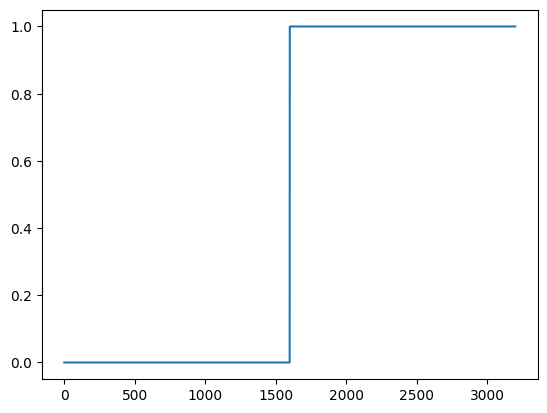

In [9]:
plt.plot(y)

Text(0, 0.5, '功率频谱')

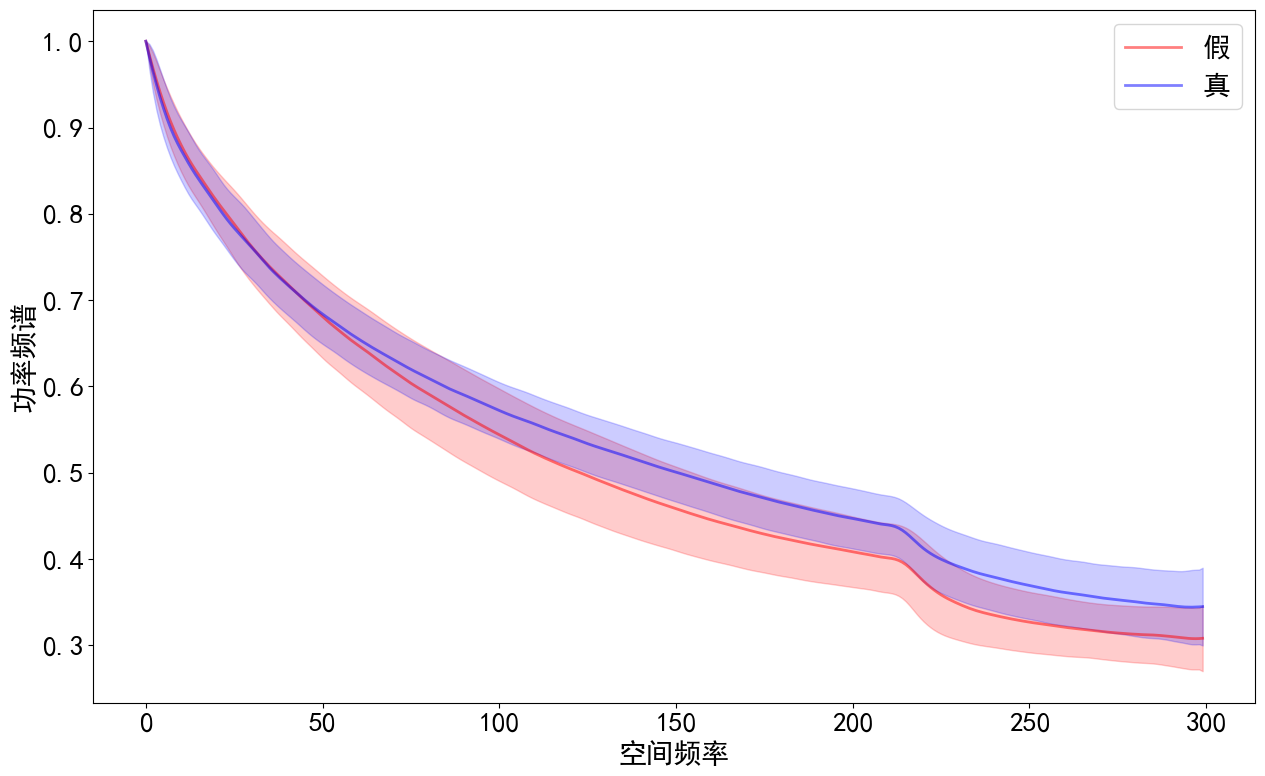

In [20]:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat)) # psd1D_org_0和psd1D_org_1用于存储原始数据的两个子集
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])
    
# Plot
x = np.arange(0, num_feat, 1) # 生成一个从0到num_feat-1的数组，代表特征的索引,步长为1
# subplots函数创建一个新的图表和一个坐标轴对象ax。figsize参数设置了图表的大小，单位为英寸，这里设置为宽15英寸、高9英寸，以便更清楚地展示数据。
fig, ax = plt.subplots(figsize=(15, 9)) 
fig.patch.set_alpha(0)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是一种支持中文的字体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='假', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='真', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("空间频率", fontsize=20)
plt.ylabel("功率频谱", fontsize=20)

In [2]:
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pickle

#train
pkl_file = open('train_3200.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]


# 创建一个SVC分类器实例，并设置其参数。C是正则化参数，kernel指定核函数类型为径向基函数（RBF），gamma是核函数的参数。
svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86,probability=True)
# 使用训练数据集X和标签y来训练SVC分类器
svclassifier_r.fit(X, y)
# 创建一个逻辑回归模型实例，并设置参数。solver指定了用于优化的算法，liblinear是一个适合小数据集的算法，max_iter是最大迭代次数。
logreg = LogisticRegression(solver='liblinear', max_iter=1000)
# 使用训练数据集X和标签y来训练逻辑回归模型。
logreg.fit(X, y)

#test
pkl_file = open('test_1000.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X_ = data["data"]
y_ = data["label"]

SVM = svclassifier_r.score(X_, y_)
LR = logreg.score(X_, y_)


# def test():
#     data = {}  # 用于存储最终的特征数据和标签
#     N = 300  # N定义了功率谱密度(PSD)的采样点数。
#     number_iter = 1  # number_iter定义了迭代次数，即处理的图像数量。
#     psd1D_total = np.zeros([number_iter, N])  # 存储所有图像的PSD的数组
#     filename = 'E:/Edge下载/643a3cbc-ea2e-4ad8-a272-3805ca89a4f9-15960.jpg'
#     with open('E:/Edge下载/643a3cbc-ea2e-4ad8-a272-3805ca89a4f9-15960.jpg', 'rb') as file:
#         # 读取文件内容到一个字节数组
#         file_bytes = file.read()
#     # 将字节数组转换为NumPy数组
#     image_array = np.frombuffer(file_bytes, np.uint8)
#     #img = cv2.imread(filename, 0)  # 以灰度模式读取图像
#     img = cv2.imdecode(image_array,0)
#     # 裁剪图像，保留图像三分之一
#     h = int(img.shape[0] / 3)
#     w = int(img.shape[1] / 3)
#     img = img[h:-h, w:-w]
#     f = np.fft.fft2(img)  # 进行二维快速傅里叶变换（FFT），得到频域表示 f
#     fshift = np.fft.fftshift(f)  # 对 FFT 结果进行频谱中心化，将零频分量移动到频谱的中心。
#     magnitude_spectrum = 20 * np.log(np.abs(fshift))  # 计算幅度谱，并取其对数得到 magnitude_spectrum
#     psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)  # 计算 magnitude_spectrum 的一维径向平均功率谱密度（PSD）
#     points = np.linspace(0, N, num=psd1D.size)
#     xi = np.linspace(0, N, num=N)
#     interpolated = griddata(points, psd1D, xi,
#                             method='cubic')  # 为了在固定的频率点上进行分析，使用 griddata 函数对 PSD 进行插值，得到 interpolated。
#     interpolated /= interpolated[0]  # 将插值后的 PSD 除以其第一个元素进行归一化。
#     psd1D_total[0, :] = interpolated  # 将归一化后的 PSD 存储到 psd1D_total 数组中
#     return psd1D_total
# 
# 
# print("predict:",svclassifier_r.predict_proba(test()))
# print("logreg:",logreg.predict_proba(test()))
print("SVM: "+str(SVM))
print("LR: "+str(LR))

SVM: 0.87
LR: 0.765
